# Projeto 2 - Ciência dos Dados

Nome: _Marco Tulio Masselli Rainho Teixeira_

Nome: _Talissa Gonçalves Albertini_

## Classificador automático de qualidade de investimentos em ações


### Descrição da Base de Dados 

A base de dados ultilizada neste projeto é composta por indicadores financeiros coletados ao longo de vários anos (1986-2020) da empresa Microsoft

Indicadores do DataSet Trimestral
* DATE: Dada de coleta das informações
* NET_INCOME: A diferença entre o lucro bruto e as despesas (em $10^6$ dólares)
* CF_FREE_CASH_FLOW: 
* CF_CASH_FROM_OPER:
* CF_CASH_FROM_INV_ACT:
* CF_CASH_FROM_FNC_ACT:
* CUR_RATIO:
* TOT_DEBT_TO_COM_EQY:
* RETURN_COM_EQY:

Indicadores do DataSet Diário
* DATE: Dada de coleta das informações
* CUR_MKT_CAP : Valor de mercado, valor de uma ação vezes o número total ed ações
* TURNOVER : Indica o quão rápido a empresa consegue arrecadar dinheito com o seu inventário
* PX LAST : Preço da ação 
* EQY_SH_OUT :
* PE RATIO :
* PX_TO_BOOK_RATIO :
* EQY_DPS :

### Técnica utilizada

Regressão logística multinomial

### Objetivo do Projeto

Este projeto tem o objetivo realizar a análise de indicadores financeiros de uma determinada ação do portfólio e responder a seguinte questão: Esta ação deve ser matida no portfólio ou não ? O critério relevante para responder essa questão é basicamente a probabilidade dessa ação valorizar durante o próximo trimestre, dado que parte significante dos indicadores são trimestrais.

In [40]:
# funcao para formatacao das ceulas

def disposicao_lateral(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    

### 1. Preparação do ambiente do Jupyter

In [41]:
%matplotlib inline
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from IPython.display import display_html

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

#from sklearn.cross_validation import train_test_split
#import plotly.graph_objs as go
#import plotly.plotly as py
#from plotly.graph_objs import *

### 2. Carregando a base de dados com os indicadores


In [42]:
xls = pd.ExcelFile('Dados_BBG.xlsx')
dft1 = pd.read_excel(xls, 'MSFT-Quarterly')
dft2 = pd.read_excel(xls, 'MSFT-Daily')

In [43]:
dft = dft1.iloc[6:133, 1:] # dft trimestral

dfd = dft2.iloc[6:, 1:] # dft diário

### 3. Tratamento do banco de dados de treinamento


In [44]:
# rectify the date columns
dft.iloc[:, 0] = dft.iloc[:, 0].dt.date 

dfd.iloc[:, 0] = dfd.iloc[:, 0].dt.date

In [45]:
# Set the column's names 

columns_dft = dft1.iloc[4,[1,3,5,7,9,11,13,15,17,19]].array  
dft.rename( columns={'Unnamed: 1':columns_dft[0]}, inplace=True )
dft.rename( columns={'Unnamed: 3':columns_dft[1]}, inplace=True )
dft.rename( columns={'Unnamed: 5':columns_dft[2]}, inplace=True )
dft.rename( columns={'Unnamed: 7':columns_dft[3]}, inplace=True )
dft.rename( columns={'Unnamed: 9':columns_dft[4]}, inplace=True )
dft.rename( columns={'Unnamed: 11':columns_dft[5]}, inplace=True )
dft.rename( columns={'Unnamed: 13':columns_dft[6]}, inplace=True )
dft.rename( columns={'Unnamed: 15':columns_dft[7]}, inplace=True )
dft.rename( columns={'Unnamed: 17':columns_dft[8]}, inplace=True )
dft.rename( columns={'Unnamed: 19':columns_dft[9]}, inplace=True )

columns_dfd = dft2.iloc[4,[1,3,5,7,9,11,13]].array  
dfd.rename( columns={'Unnamed: 1':columns_dfd[0]}, inplace=True )
dfd.rename( columns={'Unnamed: 3':columns_dfd[1]}, inplace=True )
dfd.rename( columns={'Unnamed: 5':columns_dfd[2]}, inplace=True )
dfd.rename( columns={'Unnamed: 7':columns_dfd[3]}, inplace=True )
dfd.rename( columns={'Unnamed: 9':columns_dfd[4]}, inplace=True )
dfd.rename( columns={'Unnamed: 11':columns_dfd[5]}, inplace=True )
dfd.rename( columns={'Unnamed: 13':columns_dfd[6]}, inplace=True )

In [46]:
# indicadores financeiros que serao analisados
print(columns_dft)
print(columns_dfd)

<PandasArray>
[                'DATE',           'NET_INCOME',    'CF_FREE_CASH_FLOW',
    'CF_CASH_FROM_OPER', 'CF_CASH_FROM_INV_ACT', 'CF_CASH_FROM_FNC_ACT',
            'CUR_RATIO',  'TOT_DEBT_TO_COM_EQY',       'RETURN_COM_EQY',
              'EQY_DPS']
Length: 10, dtype: object
<PandasArray>
[            'DATE',      'CUR_MKT_CAP',         'TURNOVER',
          'PX_LAST',       'EQY_SH_OUT',         'PE_RATIO',
 'PX_TO_BOOK_RATIO']
Length: 7, dtype: object


In [47]:
# Get rid of unnamed columns thar remained
dft = dft.loc[:, ~dft.columns.str.contains('^Unnamed')]

dfd = dfd.loc[:, ~dfd.columns.str.contains('^Unnamed')]

In [48]:
dfd.head()

,DATE,CUR_MKT_CAP,TURNOVER,PX_LAST,EQY_SH_OUT,PE_RATIO,PX_TO_BOOK_RATIO
6,1988-09-30,2760.9,NaN,0.3637,7590.82,23.5923,NaN
7,1988-10-03,2741.13,NaN,0.3611,7590.82,23.4234,NaN
8,1988-10-04,2793.84,NaN,0.3681,7590.82,23.8739,NaN
9,1988-10-05,2793.84,NaN,0.3681,7590.82,23.8739,NaN
10,1988-10-06,2754.31,NaN,0.3628,7590.82,20.9839,NaN


In [49]:
dft.head()

,DATE,NET_INCOME,CF_FREE_CASH_FLOW,CF_CASH_FROM_OPER,CF_CASH_FROM_INV_ACT,CF_CASH_FROM_FNC_ACT,CUR_RATIO,TOT_DEBT_TO_COM_EQY,RETURN_COM_EQY,EQY_DPS
6,1988-09-30,36.582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1988-12-31,47.485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1989-03-31,41.119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1989-06-30,45.352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1989-09-30,49.588,NaN,59.465,NaN,NaN,2.8538,8.2158,NaN,0


In [50]:
# Rectify the data type
indicators_dft = ['NET_INCOME', 'CF_FREE_CASH_FLOW', 'CF_CASH_FROM_OPER', 'CF_CASH_FROM_INV_ACT', 'CF_CASH_FROM_FNC_ACT', 'CUR_RATIO',  'TOT_DEBT_TO_COM_EQY', 'RETURN_COM_EQY', 'EQY_DPS']
for indicator in indicators_dft:
    dft[indicator] = dft[indicator].astype(float)
    
dft['DATE'] = pd.to_datetime(dft['DATE'])



indicators_dfd = ['CUR_MKT_CAP', 'TURNOVER', 'PX_LAST', 'EQY_SH_OUT', 'PE_RATIO', 'PX_TO_BOOK_RATIO']
for indicator in indicators_dfd:
    dfd[indicator] = dfd[indicator].astype(float)
    
dfd['DATE'] = pd.to_datetime(dfd['DATE'])    

In [51]:
# tipos de variavel
disposicao_lateral(dft.dtypes.to_frame(),dfd.dtypes.to_frame())

,0
DATE,datetime64[ns]
NET_INCOME,float64
CF_FREE_CASH_FLOW,float64
CF_CASH_FROM_OPER,float64
CF_CASH_FROM_INV_ACT,float64
CF_CASH_FROM_FNC_ACT,float64
CUR_RATIO,float64
TOT_DEBT_TO_COM_EQY,float64
RETURN_COM_EQY,float64
EQY_DPS,float64


In [52]:
# set date as index
dft = dft.set_index('DATE')
dfd = dfd.set_index('DATE')
dft.head()

,NET_INCOME,CF_FREE_CASH_FLOW,CF_CASH_FROM_OPER,CF_CASH_FROM_INV_ACT,CF_CASH_FROM_FNC_ACT,CUR_RATIO,TOT_DEBT_TO_COM_EQY,RETURN_COM_EQY,EQY_DPS
DATE,,,,,,,,,
1988-09-30,36.582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-12-31,47.485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-03-31,41.119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-06-30,45.352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989-09-30,49.588,NaN,59.465,NaN,NaN,2.8538,8.2158,NaN,0.0


In [53]:
# converção de tabela diaria em mensal e uniormizacao dos nomes dos df
dfm1 = dft.resample('M').mean()
dfm2 = dfd.resample('M').mean()

In [54]:
# cria a coluna da variavel target , para ser usada na regressao logistica 
dfm2['return'] = (dfm2['PX_LAST'].diff()>0).astype('int')

In [55]:
# junta os data frames 
dfmerged = pd.DataFrame()
dfmerged = dfm1.merge(dfm2, left_on='DATE', right_on='DATE')
dfmerged = dfmerged.fillna(method = 'bfill')
dfmerged

,NET_INCOME,CF_FREE_CASH_FLOW,CF_CASH_FROM_OPER,CF_CASH_FROM_INV_ACT,CF_CASH_FROM_FNC_ACT,CUR_RATIO,TOT_DEBT_TO_COM_EQY,RETURN_COM_EQY,EQY_DPS,CUR_MKT_CAP,TURNOVER,PX_LAST,EQY_SH_OUT,PE_RATIO,PX_TO_BOOK_RATIO,return
DATE,,,,,,,,,,,,,,,,
1988-09-30,36.582,323.0,59.465,-173.0,-234.0,2.8538,8.2158,39.2820,0.00,2.760896e+03,5.117278e+08,0.363700,7590.816000,23.592300,6.880879,0
1988-10-31,47.485,323.0,59.465,-173.0,-234.0,2.8538,8.2158,39.2820,0.00,2.736929e+03,5.117278e+08,0.357767,7675.412571,21.057371,6.880879,0
1988-11-30,47.485,323.0,59.465,-173.0,-234.0,2.8538,8.2158,39.2820,0.00,2.561769e+03,5.117278e+08,0.331514,7727.472000,19.171919,6.880879,0
1988-12-31,47.485,323.0,59.465,-173.0,-234.0,2.8538,8.2158,39.2820,0.00,2.641944e+03,5.117278e+08,0.341890,7727.472000,19.771929,6.880879,1
1989-01-31,41.119,323.0,59.465,-173.0,-234.0,2.8538,8.2158,39.2820,0.00,2.835834e+03,5.117278e+08,0.366986,7727.472000,19.744210,6.880879,1
1989-02-28,41.119,323.0,59.465,-173.0,-234.0,2.8538,8.2158,39.2820,0.00,3.249083e+03,5.117278e+08,0.420453,7727.472000,22.341716,6.880879,1
1989-03-31,41.119,323.0,59.465,-173.0,-234.0,2.8538,8.2158,39.2820,0.00,2.902680e+03,5.117278e+08,0.375641,7727.472000,19.959736,6.880879,0
1989-04-30,45.352,323.0,59.465,-173.0,-234.0,2.8538,8.2158,39.2820,0.00,2.754253e+03,5.117278e+08,0.356415,7727.472000,18.588380,6.880879,0
1989-05-31,45.352,323.0,59.465,-173.0,-234.0,2.8538,8.2158,39.2820,0.00,2.955734e+03,5.117278e+08,0.382491,7727.472000,19.884314,6.880879,1


In [56]:
 dft.describe().T

,count,mean,std,min,25%,50%,75%,max
NET_INCOME,127.0,3027.523835,3006.771768,-6302.0000,447.50000,2528.0000,4975.00000,13187.0000
CF_FREE_CASH_FLOW,103.0,4629.436893,2961.961786,289.0000,2513.50000,3890.0000,6979.50000,13737.0000
CF_CASH_FROM_OPER,123.0,4672.562041,3953.502380,56.7790,1417.50000,4014.0000,7186.50000,17504.0000
CF_CASH_FROM_INV_ACT,92.0,-2885.760870,4742.670659,-18470.0000,-5066.25000,-2546.0000,-1043.00000,23414.0000
CF_CASH_FROM_FNC_ACT,91.0,-3130.967033,5231.527435,-33618.0000,-4290.00000,-2465.0000,-535.00000,14339.0000
CUR_RATIO,123.0,3.110915,0.858292,1.4469,2.59550,2.9291,3.64305,5.2892
TOT_DEBT_TO_COM_EQY,123.0,18.693139,33.145313,0.0000,0.00000,0.0000,19.85440,127.8012
RETURN_COM_EQY,119.0,31.059434,10.538520,10.8038,22.99115,31.8966,39.24010,54.0553
EQY_DPS,123.0,0.159821,0.319924,0.0000,0.00000,0.0800,0.23000,3.0800


### 4. Análise exploratória dos dados

In [57]:
# descricao dos df
# disposicao_lateral(dft1.describe().T, dft2.describe().T)

In [58]:
# Skewness of the indicators
#dft1.skew()
#dft2.skew()
# disposicao_lateral(dft1.skew().to_frame(), dft2.skew().to_frame())

In [59]:
# Null values
#dft1.isna().sum()
#dft2.isna().sum()

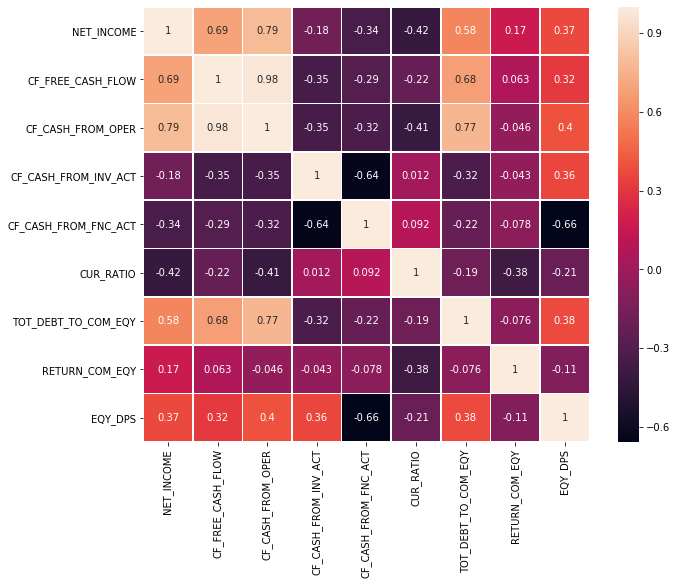

In [60]:
# correlation table dft1
fig = plt.figure(figsize=(10,8))
sb.heatmap(dfm1.corr(),annot=True,linewidths=.5);

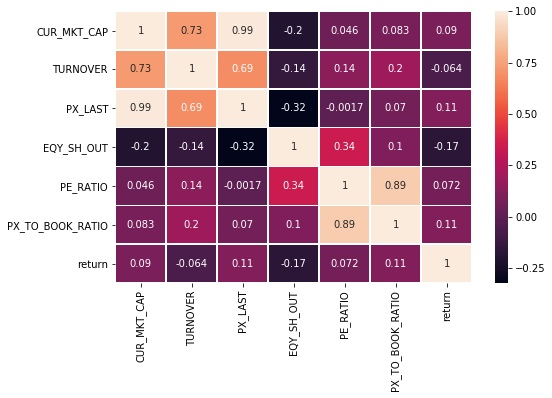

In [61]:
# correlation table dft2
fig = plt.figure(figsize=(8,5))
sb.heatmap(dfm2.corr(),annot=True,linewidths=.5);

In [62]:
# litsas de correlacao entre a variavel targef e as variaveis features
price_corr =  dfmerged.corr()['PX_LAST'].sort_values(ascending=False).to_frame()
price_corr

,PX_LAST
PX_LAST,1.000000
CUR_MKT_CAP,0.988836
CF_CASH_FROM_OPER,0.838292
TOT_DEBT_TO_COM_EQY,0.784705
CF_FREE_CASH_FLOW,0.762940
TURNOVER,0.753113
NET_INCOME,0.750400
EQY_DPS,0.411533
return,0.098119
PX_TO_BOOK_RATIO,0.055791


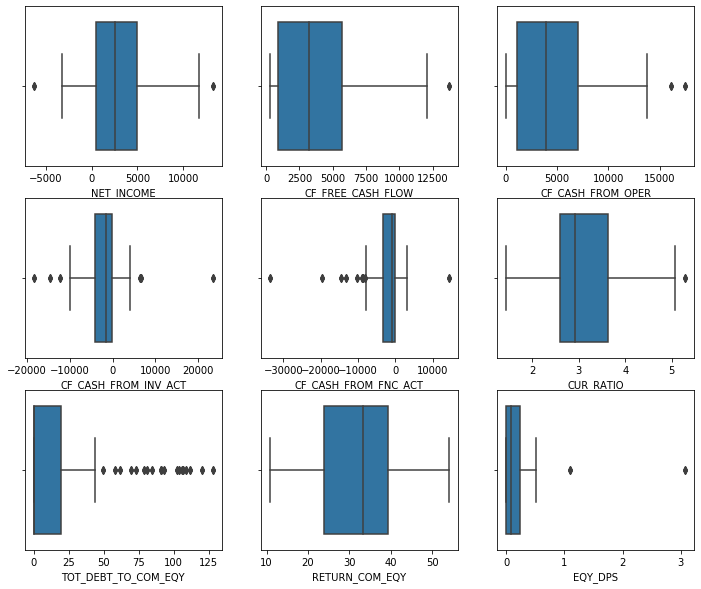

In [63]:
# Analise de outliers dos indicadores trimestrais

fig = plt.figure(figsize=(12, 10))

for indicator in indicators_dft:
    plt.subplot(3, 3, indicators_dft.index(indicator)+1)
    #plt.title(indicator)
    sb.boxplot(x=dfmerged[indicator])
plt.show()

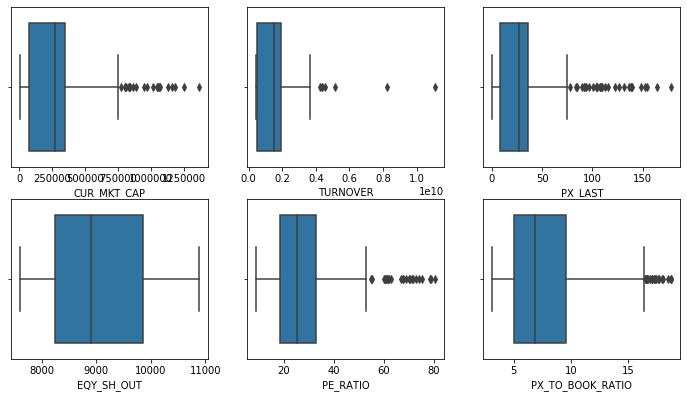

In [64]:
# Analise de outliers dos indicadores diarios

fig = plt.figure(figsize=(12, 10))

for indicator in indicators_dfd:
    plt.subplot(3, 3, indicators_dfd.index(indicator)+1)
    #plt.title(indicator)
    sb.boxplot(x=dfmerged[indicator])
plt.show()



C:\Program Files\Anaconda\lib\site-packages\pandas\plotting\_core.py:1801: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


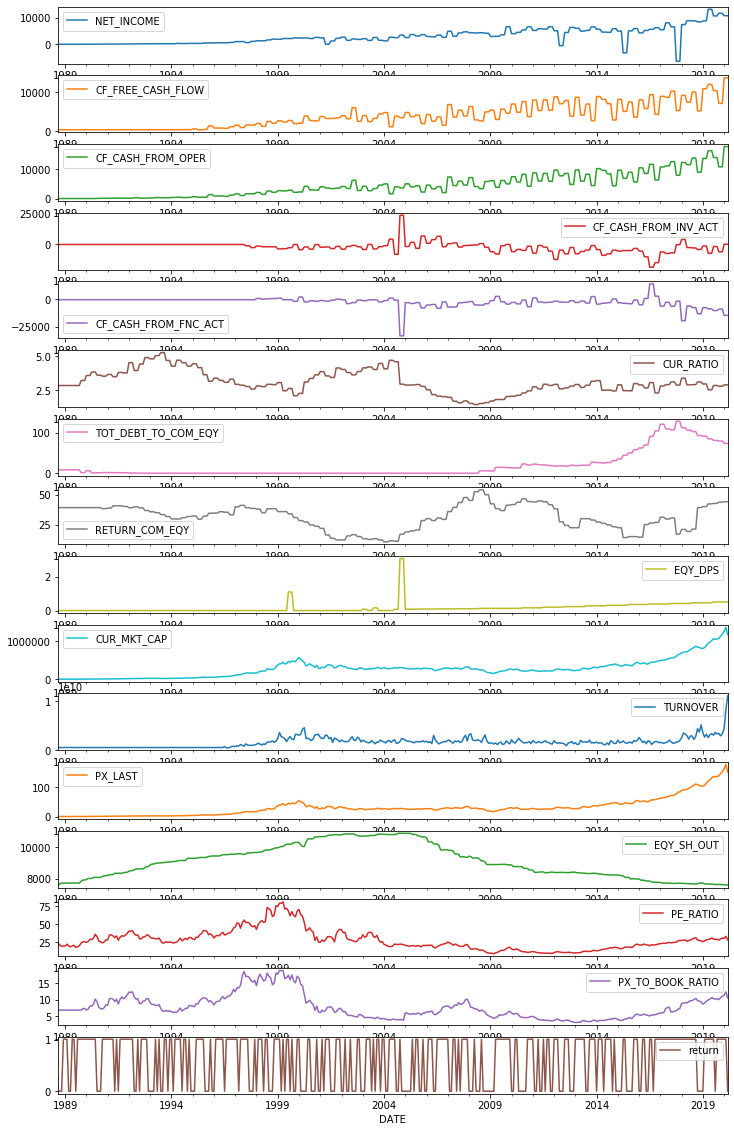

In [65]:
# visualizaca dos indicadores no tempo, com foco na relacao entre eles, de cescimento e decrescimento
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,20))
dfmerged.plot(ax = axes[1],subplots=True);


### 5. Classificador

In [66]:
# funcao da regressao logistica multipla
def Classifier(df):
    target = df.loc[:,'return'].head()
    indicators = df.iloc[:,:-1].head()
    train_indicators, test_indicators, train_target, test_target = train_test_split(indicators, target, train_size=0.7)
    linear_model.LogisticRegression().fit(train_indicators, train_target)
    # retorna valores de test_target, baseado nos valores de test_indicators
    return LogisticRegression().predict(test_indicators)

In [67]:
Classifier(dftmerged.fillna(method='bfill'))

C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


NotFittedError: This LogisticRegression instance is not fitted yet

In [ ]:
# teste de acuracia do classificador

LogisticRegression().score(test_indicators, test_target)

In [ ]:
# bobliografia 

# regressao logistica: https://dataaspirant.com/2017/05/15/implement-multinomial-logistic-regression-python/ 
# outliers: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [ ]:
# maiores desafios desse projeto
# * Dados com comportamentos oscilatórios em geral são mais difíceis de lidar com outliers
# * Bancos de dados da Bloomberg, eventualmente, podem vir com inúmeros problemas de formatação no próprio Excel, como ..., e isso exige um trabalho extenso na manipulação do formato do Dataset e na análise exploratória 
# * Trabalhar com índices no formato DateTime oferece várias possibilidades um tanto quanto refinadas na manipulação de informações, mas também pode ser desafiador no aspecto de ...
# * A maioria dos indicadores financeiros são coletados mensalmente e trimestralmente, o que resulta em bancos de dados relativamente pequenos, ainda mais se for considerado que a maioria das empresas não são muito antigas 
# * A grande maioria dos modelos financeiros disponibilizados são baseados somente no comportamento dos preços das ações, realizada o uma análise puramente matemática
